In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-india-movies/IMDb Movies India.csv


# Importing liabraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder


# Load the Data

In [14]:
# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-india-movies/IMDb Movies India.csv', encoding='ISO-8859-1')

print("Dataset Shape:", df.shape)
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Shape: (15509, 10)
                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2019)  110 min  Comedy, Romance   
4                   ...And Once Again  (2010)  105 min            Drama   

   Rating Votes            Director       Actor 1             Actor 2  \
0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   

           Actor 3  
0  Rajendra Bhatia  
1    Arvind Jangid  
2       Roy Angana  

# EDA



Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB
None

Summary Statistics:
            Rating
count  7919.000000
mean      5.841621
std       1.381777
min       1.100000
25%       4.900000
50%       6.000000
75%       6.800000
max      10.000000

Checking for missing values:
Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


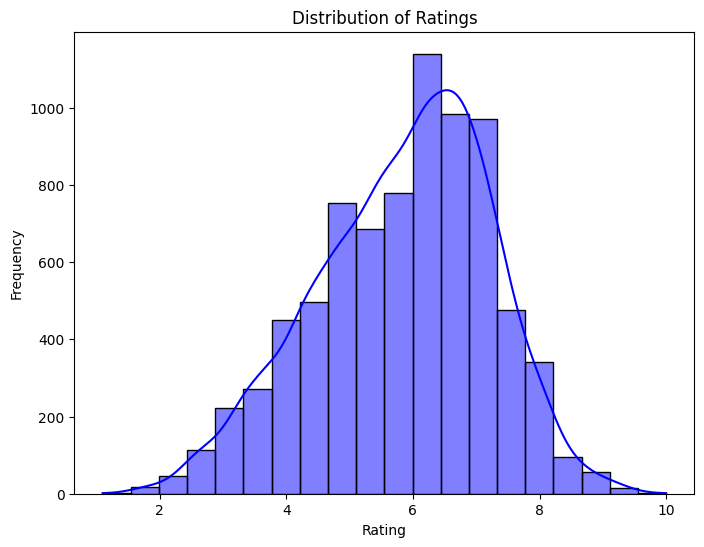

In [15]:
print("\nBasic Information:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nChecking for missing values:")
print(df.isnull().sum())

# Visualizing the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], kde=True, bins=20, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Data Preprocessing

In [17]:
# Clean and convert the year column
#Dropping null values in the entire row except name column
df = df.dropna(subset=['Year', 'Duration', 'Genre','Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'],how='all')
df.shape
df.dropna(subset=['Duration','Rating', 'Votes'], inplace = True)
#Filling the null values of Genre, Director and Actor 1 columns with its mode value
df['Genre'].fillna(df['Genre'].mode()[0], inplace=True)
df['Director'].fillna(df['Director'].mode()[0], inplace=True)
df['Actor 1'].fillna(df['Actor 1'].mode()[0], inplace=True)

Actors = pd.concat([df['Actor 1'], df['Actor 2'], df['Actor 3']]).dropna().value_counts()
Actors.head(5)
#Filling the null values of Actor 2 and Actor 3 columns with a value 'None'.
df['Actor 2'].fillna('None', inplace=True)
df['Actor 3'].fillna('None', inplace=True)
#Extracting only the text part from the Name column
df['Name'] = df['Name'].str.extract('([A-Za-z\s\'\-]+) #.')
# Removing the brackets'()' from Year column and converting 'Year' column to numeric datatype
df['Year'] = df['Year'].str.replace(r'[()]', '', regex=True).astype(int)
# Converting 'Duration' to numeric datatype and removing the min from it and keeping only numerical part
df['Duration'] = pd.to_numeric(df['Duration'].str.replace(r' min', '', regex=True), errors='coerce')
df['Votes'] = pd.to_numeric(df['Votes'].str.replace(',', ''), errors='coerce')

In [18]:
# Splitting the genre into different columns to keep only unique genres 
df['Genre'] = df['Genre'].str.split(', ')
df = df.explode('Genre')
#Displaying each single Genre count after splitting the multiple genres
genre_counts = {}
for genre in df['Genre'].values.flatten():
    if genre is not None:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1
GenreCounts = {genre: count for genre, count in sorted(genre_counts.items())}
for genre, count in GenreCounts.items():
    print(f"{genre}: {count}")

Action: 1699
Adventure: 284
Animation: 56
Biography: 126
Comedy: 1352
Crime: 878
Documentary: 130
Drama: 3878
Family: 428
Fantasy: 148
History: 103
Horror: 205
Music: 55
Musical: 416
Mystery: 308
News: 2
Romance: 1383
Sci-Fi: 35
Sport: 44
Thriller: 684
War: 34
Western: 2


In [20]:
df.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,NaN,2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,NaN,2019,110,Comedy,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
3,NaN,2019,110,Romance,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,NaN,1997,147,Comedy,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
5,NaN,1997,147,Drama,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor


In [24]:
# Combine actors into a single feature
df['actors_combined'] = df['Actor 1'] + ', ' + df['Actor 2'] + ', ' + df['Actor 3']

# Encode categorical features
categorical_cols = ['Genre', 'Director', 'actors_combined']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
encoded_features.columns = encoder.get_feature_names_out(categorical_cols)

df_reset = df[['Year', 'Duration', 'Votes']].reset_index(drop=True)
encoded_features_reset = encoded_features.reset_index(drop=True)
rating_reset = df['Rating'].reset_index(drop=True)

# Combine encoded features with numerical data
final_data = pd.concat([
    df_reset,
    encoded_features_reset,
    rating_reset
], axis=1)

# Prepare data for training
X = final_data.drop(columns=['Rating'])
y = final_data['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Model training and evaluation

In [25]:
# Split the data into train and test sets
X = final_data.drop(columns=['Rating'])
y = final_data['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


Mean Squared Error: 0.5705211763265308
R-squared Score: 0.695972885239807
